# Installations and Imports

In [ ]:
! pip install wfdb

In [ ]:
! pip install biosignalsnotebooks

In [ ]:
! pip install bokeh==2.3.3

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import biosignalsnotebooks as bsnb
import wfdb
from scipy.signal import detrend
import seaborn as sns

In [ ]:
# Downloading the NSRDB dataset
# fs = 128
! wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/

In [ ]:
# Downloading the MIT-BIH dataset
# fs = 360
# Containing Anomaly
# Should get all possible EKMs
! wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

In [ ]:
# Downloading the PTBDB dataset
# fs = 1000
# Containing Anomaly
# Should get all possible EKMs
! wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/

In [ ]:
# Downloading the BUTQDB dataset
# fs = 1000
! wget -r -N -c -np https://physionet.org/files/butqdb/1.0.0/

In [ ]:
! rm -r EKM_dataset

In [ ]:
! mkdir EKM_dataset
! mkdir EKM_dataset/train
! mkdir EKM_dataset/test

In [ ]:
import os
from datetime import datetime

In [ ]:
from PIL import Image
import numpy as np

# Functions

In [ ]:
# METHODS AND UTILITITES

# How the EKM is built
def electrocardiomatrix(distance, r_peaks, filtered_ecg, init_window, peaks_window):
    init_seg = int(0.2 * distance)
    fin_seg = int(1.5 * distance)
    all_segments = []
    for peak in r_peaks[init_window:init_window + peaks_window]:
        if peak - init_seg < 0:
            segment = filtered_ecg[0:peak + fin_seg]
        else:
            segment = filtered_ecg[peak - init_seg:peak + fin_seg]
        all_segments.append(segment[:,np.newaxis])
    if all_segments[0].shape[0] < all_segments[1].shape[0]:
        zeros = np.zeros(int(all_segments[1].shape[0])-int(all_segments[0].shape[0]))[:, np.newaxis]
        new_segment = np.concatenate((zeros, all_segments[0]))
        all_segments[0] = new_segment
    try:
      ecm = np.concatenate(all_segments, 1)
    except ValueError:
      return None
    return ecm.T

# Normalizing method
def normalize(signal):
    a, b = -1, 1
    c = b - a
    aux = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    norm_ecg = c * aux + a
    return norm_ecg

# Filtering the EKG signal and obtaining its R-peaks with biosignalsnotebook
def process_ecg(unfiltered_ecg, fs):
    # Step 1 of Pan-Tompkins Algorithm - ECG Filtering (Bandpass between 5 and 15 Hz)
    filtered_signal = bsnb.detect._ecg_band_pass_filter(unfiltered_ecg, fs)
    # Step 2 of Pan-Tompkins Algorithm - ECG Differentiation
    differentiated_signal = np.diff(filtered_signal)
    # Step 3 of Pan-Tompkins Algorithm - ECG Rectification
    squared_signal = differentiated_signal * differentiated_signal
    # Step 4 of Pan-Tompkins Algorithm - ECG Integration ( Moving window integration )
    nbr_sampls_int_wind = int(0.080 * fs)
    integrated_signal = np.zeros_like(squared_signal)
    cumulative_sum = squared_signal.cumsum()
    integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] - cumulative_sum[
                                                                                      :-nbr_sampls_int_wind]) / nbr_sampls_int_wind
    integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / np.arange(1, nbr_sampls_int_wind + 1)
    # Initialisation of the R peak detection algorithm
    rr_buffer, signal_peak_1, noise_peak_1, threshold = bsnb.detect._buffer_ini(integrated_signal, fs)
    # Detection of possible and probable R peaks
    probable_peaks, possible_peaks = bsnb.detect._detects_peaks(integrated_signal, fs)
    # Identification of definitive R peaks
    definitive_peaks = bsnb.detect._checkup(probable_peaks, integrated_signal, fs, rr_buffer, signal_peak_1,
                                            noise_peak_1, threshold)
    # Conversion to integer type.
    definitive_peaks = np.array(list(map(int, definitive_peaks)))
    # Correcting step
    map_integers = definitive_peaks - 40 * (fs / 1000)
    definitive_peaks_reph = np.array(list(map(int, map_integers)))
    return definitive_peaks_reph, filtered_signal

# Calculates the mean distance between all peaks for each user
def peak_distance(r_peaks):
    dist = []
    for i in range(len(r_peaks)):
        if r_peaks[i] == r_peaks[-1]:
            break
        distance = r_peaks[i + 1] - r_peaks[i]
        if i == 0:
            dist.append(distance)
            continue
        if distance > np.mean(dist) + np.std(dist) * 2:
            continue
        else:
            dist.append(distance)
    return np.mean(dist)

def save_ecm(dataset_name, norm_ecm, train_filled, test_filled, train_ecms, test_ecms, path_test, path_train, train_split_percent, key, i, f, j):
    # splitting the test and train EKMs and saving them in path
    # format of {path_test}/_NumberOfRbfsInAEKM_bpf-ekm-test/train-{key=user id}-{i=serial Number}
    rand = np.random.uniform(0, 1)
    if rand <= (1 - train_split_percent) or train_filled:
        plt.savefig(f"{path_test}/5bpf-ekm-{dataset_name}-test-{key}-{str(i)}",bbox_inches='tight', pad_inches=0)
        j += 1
        if j > test_ecms:
            test_filled = True

    elif rand > (1 - train_split_percent) or test_filled:
        plt.savefig(f"{path_train}/5bpf-ekm-{dataset_name}-train-{key}-{str(i)}",bbox_inches='tight', pad_inches=0)
        f += 1
        if f >= train_ecms:
            train_filled = True

    return j,f

In [ ]:
def ptb_file_content_fixer(hea_file_path, original_name, new_just_name):
  with open(hea_file_path, 'r') as f:
      # Read the entire content of the file
      content = f.read()

  new_content = content.replace(original_name, new_just_name)
  return new_content

In [ ]:
# Gathering .dat files of PTB dataset
# For PTB dataset

if "ptbdb_dat_files" in os.listdir("/content"):
  ! rm -r ptbdb_dat_files
! mkdir ptbdb_dat_files

ecg_mine_path = "/content/physionet.org/files/ptbdb/1.0.0"
ptb_labeling_dict = {}
ptb_labeling_file_to_user = {}

files_list = os.listdir(ecg_mine_path)
# Extracting ECG files of patients and saving them
# into /content/ptbdb_dat_files directory
for patient_folder in files_list:
  # chckeing if the folder is a patient's files or not
  patient_folder_or_not = str(patient_folder)[:-3]
  if patient_folder_or_not != "patient":
    continue

  # key is user's id
  key = patient_folder[-3:]
  ptb_labeling_dict[key] = []
  each_patient_files = os.listdir(f"{ecg_mine_path}/{patient_folder}")
  for f in each_patient_files:
    ! cp "$ecg_mine_path/$patient_folder/$f" ptbdb_dat_files
    ptb_labeling_dict[key].append(f)
    ptb_labeling_file_to_user[f] = key

In [ ]:
# Getting the users ECG signals files (.dat files)
# Up to the dataset we want to use, uncomment the
# relative path of the dataset

# ecg_mine_path = "/content/physionet.org/files/nsrdb/1.0.0"
ecg_mine_path = "/content/physionet.org/files/mitdb/1.0.0"
# ecg_mine_path = "/content/ptbdb_dat_files"

files_list = os.listdir(ecg_mine_path)
users_ecg_file = []

for f in files_list:
  f_extention = f.split(".")[-1]
  if f_extention == "dat":
    users_ecg_file.append(f)

In [ ]:
# Should be 18 for NSRDB
# Should be 48 for MIT-BIHDB
# Should be 549 for PTBDB
len(users_ecg_file)

48

In [ ]:
def distance_calculaor(filtered_ecg, peaks):
  detrend_signal = detrend(filtered_ecg)
  print('\t DETREND applied')
  norm_ecg = normalize(detrend_signal)
  print('\t NORMALIZATION applied')
  # The distance calculation, may take a while
  distance = peak_distance(peaks)
  print('\t Distance calculated')

  return norm_ecg, distance

In [ ]:
# dataset_ecg_dict(usr_ecg_file, fs)

In [ ]:
dat_file = "/content/physionet.org/files/mitdb/1.0.0/100.dat"
ddbb_record = dat_file.replace(".dat", "")
sig, fields = wfdb.rdsamp(ddbb_record)

In [ ]:
sig

array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.675, -0.365],
       [-0.765, -0.335],
       [-1.28 ,  0.   ]])

In [ ]:
sig[0]

array([-0.145, -0.065])

In [ ]:
len(sig)

650000

In [ ]:
fields

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}

In [ ]:
def dataset_ecg_dict(usr_ecg_file, fs):
  # Getting peaks of ecg signal of user
  print(". Getting peaks of ecg signal of user")
  dat_file = f"{ecg_mine_path}/{usr_ecg_file}"
  ddbb_record = dat_file.replace(".dat", "")
  sig, fields = wfdb.rdsamp(ddbb_record)
  unfiltered_ecg = sig[:, 0]
  peaks, filtered_ecg = process_ecg(unfiltered_ecg, fs)

  # Number of peaks to be taken (from 0 to 6)
  # key is user id
  print(". Calculating distance")
  norm_ecg, distance = distance_calculaor(filtered_ecg, peaks)

  return norm_ecg, distance, peaks

In [ ]:
def dataset_extractor(dataset_name, usr_ecg_file_name, usr_ecg_dict_info, total_ecms):
  key = usr_ecg_file_name.split(".")[0]
  data_obtained = []
  distances = []
  negative = True
  j, f, i, init_window = 0, 0, 0, 0
  train_split_percent = 0.8
  test_ecms = int((1 - train_split_percent) * total_ecms)
  train_ecms = total_ecms - test_ecms
  train_filled, test_filled = False, False

  # [norm_ecg, distance, peaks]
  peaks = usr_ecg_dict_info[2]
  distance = usr_ecg_dict_info[1]
  norm_ecg = usr_ecg_dict_info[0]

  fig_width_px = 33
  fig_height_px = 21

  print(". Getting EKMs")
  while((j+f)<total_ecms):
    if (init_window >= len(peaks)) or (init_window >= len(peaks)-1): break
    ecm = electrocardiomatrix(distance, peaks, norm_ecg, init_window, peaks_window)
    if ecm is None: break
    distance = int(distance)
    norm_ecm = normalize(ecm)

    fig = plt.figure(num=1, clear=True, figsize=(fig_width_px / 80, fig_height_px / 80))
    ax = fig.add_subplot()
    ax.axis('off')

    sns.heatmap(norm_ecm, xticklabels=False, yticklabels=False, cbar=False)
    # plt.tight_layout()

    # todo: we don't really use norm_ecm parameter in save_ecm function so why we are sending it?
    j, f = save_ecm(dataset_name, norm_ecm, train_filled, test_filled, train_ecms, test_ecms, test_path, train_path, train_split_percent, key, i, f, j)
    init_window += bpf
    i += 1
    # break

In [ ]:
def pretier_print(pos, userNumber, usr_ecg_file_name):
  if pos == "begin":
    [print("-", end="") for i in range(30)]
    print("")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print(f"-> User No.{userNumber}")
    print("")
    print(usr_ecg_file_name)

  if pos == "end":
    print("")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print("")

In [ ]:
def variable_to_file_to_drive_save(variable, saved_file_name):
  # To save a variable into text file then transfer it into drive

  # Define the source file path and destination path
  source_file_path = saved_file_name
  destination_directory = '/content/drive/MyDrive/ECG project'

  # Writing the variable into a file
  import pickle

  f = open(saved_file_name, 'wb')
  pickle.dump(variable, f)

  import shutil

  # Move the file to Google Drive
  shutil.move(source_file_path, destination_directory)

In [ ]:
def loading_drive_saved_obj_to_variable(destination_path):
  # Loaing an object(variable) being saved into a file (.txt), into a variable
  import pickle

  # Open the file in binary read mode
  with open(destination_path, 'rb') as fi:
      loaded_dict = pickle.load(fi)

  print(loaded_dict)

  return loaded_dict

# EKM dataset creation (NSRDB)





> NSRDB

In [ ]:
train_path = f'EKM_dataset/train'
test_path = f'EKM_dataset/test'
bpf = 5
peaks_window = bpf-1

In [ ]:
# Creating dict of ECG signal of users for NSRDB
ecg_dict = {}
fs = 128

for index, usr_ecg_file in enumerate(users_ecg_file):
  pretier_print("begin", index, usr_ecg_file)

  norm_ecg, distance, peaks = dataset_ecg_dict(usr_ecg_file, fs)
  ecg_dict[usr_ecg_file] = [norm_ecg, distance, peaks]

  pretier_print("end", index, usr_ecg_file)

------------------------------
2023-08-13 16:20:43
-> User No.0

16420.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-13 16:30:53

------------------------------
2023-08-13 16:30:53
-> User No.1

17052.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-13 16:37:41

------------------------------
2023-08-13 16:37:41
-> User No.2

19090.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-13 16:42:52

------------------------------
2023-08-13 16:42:52
-> User No.3

16265.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-13 16:51:58

------------------------------
2023-08-13 16:51:58
-> User No.4

19088.dat
. Getting peaks of ecg signal of user

In [ ]:
# Name of the ecg file
saved_ecg_dict_file_name = 'ecg_dict.txt'

# Define the source file path
source_file_path = saved_ecg_dict_file_name

# Define the destination directory path in Google Drive
destination_directory = '/content/drive/MyDrive/ECG project'

In [ ]:
# Saving the ecg dict
import pickle

f = open(saved_ecg_dict_file_name, 'wb')
pickle.dump(ecg_dict, f)

In [ ]:
! ls -ltrh

total 8.0K
drwxr-xr-x 1 root root 4.0K Jul  5 13:38 sample_data
drwxr-xr-x 4 root root 4.0K Jul  7 13:57 EKM_dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls -ltrh /content/drive/MyDrive/ECG\ project

total 2.0G
-rw------- 1 root root 1.6G Jun 25 15:57 ecg_dict.txt
-rw------- 1 root root  21M Jul  1 19:29 EKM_dataset_5bpf.zip
-rw------- 1 root root 343M Jul  7 17:03 train_x.txt
-rw------- 1 root root 845K Jul  7 17:03 train_y.txt
-rw------- 1 root root 211K Jul  7 17:03 test_y.txt
-rw------- 1 root root  86M Jul  7 17:03 test_x.txt


In [ ]:
import shutil

# Move the file to Google Drive
shutil.move(source_file_path, destination_directory)

In [ ]:
# Saving the ecg dict
import pickle
saved_ecg_dict_file_name = 'ecg_dict.txt'

f = open(saved_ecg_dict_file_name, 'wb')
pickle.dump(ecg_dict, f)

In [ ]:
import pickle

# Open the file in binary read mode
with open(f"{destination_directory}/{saved_ecg_dict_file_name}", 'rb') as fi:
    loaded_dict = pickle.load(fi)

print(loaded_dict)

{'19830.dat': [array([-0.0600579 , -0.06092964, -0.06112133, ..., -0.05328662,
       -0.05611166, -0.06005789]), 74.6526981510678, array([     42,     106,     170, ..., 9723298, 9723381, 9723464])], '16273.dat': [array([-0.07776593, -0.13284589, -0.21580669, ..., -0.07809676,
       -0.07793206, -0.07776628]), 96.3399380371427, array([      3,      81,     158, ..., 9516513, 9516606, 9516695])], '16773.dat': [array([-0.19317175, -0.18880082, -0.18528055, ..., -0.19329821,
       -0.19324086, -0.19317171]), 102.4864541098415, array([      44,      150,      257, ..., 10001851, 10001980, 10002099])], '17453.dat': [array([-0.11508636, -0.14396507, -0.18171703, ..., -0.11353763,
       -0.11431947, -0.1150866 ]), 87.95961769555376, array([     85,     175,     264, ..., 9533542, 9533633, 9533727])], '19140.dat': [array([-0.24261466, -0.27083786, -0.29536741, ..., -0.24461064,
       -0.24373161, -0.24261479]), 63.482608695652175, array([     14,      78,     142, ..., 9220738, 9220837, 9

In [ ]:
len(loaded_dict['19830.dat'][2])

110412

In [ ]:
# for NSRBD
total_ecms = 3000

Each user almost takes 4 minutes to extracte all its EKMs, and we have 18 users, so it will take almost 4*18=72 minutes which is about 1.2 hours (1 hours, 12 minutes) for each bpf.

------------------------------
2023-08-13 18:38:08
-> User No.0

16420.dat
. Getting EKMs

2023-08-13 18:41:39

------------------------------
2023-08-13 18:41:39
-> User No.1

17052.dat
. Getting EKMs

2023-08-13 18:45:06

------------------------------
2023-08-13 18:45:06
-> User No.2

19090.dat
. Getting EKMs

2023-08-13 18:48:34

------------------------------
2023-08-13 18:48:34
-> User No.3

16265.dat
. Getting EKMs

2023-08-13 18:52:01

------------------------------
2023-08-13 18:52:01
-> User No.4

19088.dat
. Getting EKMs

2023-08-13 18:55:29

------------------------------
2023-08-13 18:55:30
-> User No.5

16273.dat
. Getting EKMs

2023-08-13 18:58:59

------------------------------
2023-08-13 18:58:59
-> User No.6

16272.dat
. Getting EKMs

2023-08-13 19:02:27

------------------------------
2023-08-13 19:02:27
-> User No.7

19830.dat
. Getting EKMs

2023-08-13 19:05:53

------------------------------
2023-08-13 19:05:53
-> User No.8

19093.dat
. Getting EKMs

2023-08-13 19

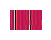

In [ ]:
# Creating dataset of EKMs [NSRDB]
import gc

# ecg_dict = loaded_dict
users_ecg_file = list(ecg_dict.keys())

for index, usr_ecg_file in enumerate(users_ecg_file):
  pretier_print("begin", index, usr_ecg_file)
  dataset_extractor("NSRDB", usr_ecg_file, ecg_dict[usr_ecg_file], total_ecms)
  pretier_print("end", index, usr_ecg_file)
  gc.collect()
  # break

# EKM dataset creation (MIT-BIHDB)


> MIT-BIHDB





In [ ]:
train_path = f'EKM_dataset/train'
test_path = f'EKM_dataset/test'
bpf = 5
peaks_window = bpf-1

In [ ]:
# Creating dict of ECG signal of users for MIT-BIH dataset
ecg_dict = {}
fs = 360
for index, usr_ecg_file in enumerate(users_ecg_file):
  pretier_print("begin", index, usr_ecg_file)

  norm_ecg, distance, peaks = dataset_ecg_dict(usr_ecg_file, fs)
  ecg_dict[usr_ecg_file] = [norm_ecg, distance, peaks]

  pretier_print("end", index, usr_ecg_file)

------------------------------
2023-08-13 13:04:42
-> User No.0

123.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-13 13:04:43

------------------------------
2023-08-13 13:04:43
-> User No.1

209.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-13 13:04:45

------------------------------
2023-08-13 13:04:45
-> User No.2

201.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-13 13:04:45

------------------------------
2023-08-13 13:04:45
-> User No.3

111.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-13 13:04:46

------------------------------
2023-08-13 13:04:46
-> User No.4

205.dat
. Getting peaks of ecg signal of user
. Calcula

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls -ltrh /content/drive/MyDrive/ECG\ project

total 2.0G
-rw------- 1 root root 1.6G Jun 25 15:57 ecg_dict.txt
-rw------- 1 root root  21M Jul  1 19:29 EKM_dataset_5bpf.zip
-rw------- 1 root root 343M Jul  7 17:03 train_x.txt
-rw------- 1 root root 845K Jul  7 17:03 train_y.txt
-rw------- 1 root root 211K Jul  7 17:03 test_y.txt
-rw------- 1 root root  86M Jul  7 17:03 test_x.txt


In [ ]:
# Name of the ecg file
saved_ecg_dict_file_name = 'MIT-BIHDB_ecg_dict.txt'

# Define the source file path
source_file_path = saved_ecg_dict_file_name

# Define the destination directory path in Google Drive
destination_directory = '/content/drive/MyDrive/ECG project'

In [ ]:
variable_to_file_to_drive_save(ecg_dict, saved_ecg_dict_file_name)

In [ ]:
f"{destination_directory}/{saved_ecg_dict_file_name}"

'/content/drive/MyDrive/ECG project/MIT-BIHDB_ecg_dict.txt'

In [ ]:
ecg_dict = loading_drive_saved_obj_to_variable(f"{destination_directory}/{saved_ecg_dict_file_name}")

{'104.dat': [array([-0.04772107, -0.06094451, -0.072035  , ..., -0.08405221,
       -0.06892113, -0.04772364]), 254.3742926434923, array([     9,    306,    605, ..., 649290, 649570, 649866])], '105.dat': [array([ 0.08682748,  0.08867434,  0.08968956, ..., -0.15564498,
       -0.0488368 ,  0.08683942]), 242.47451130701418, array([   187,    449,    698, ..., 649212, 649461, 649732])], '228.dat': [array([-0.10803707, -0.10582131, -0.10288877, ..., -0.36034719,
       -0.25522108, -0.10802844]), 239.1461026243635, array([   152,    425,    718, ..., 649099, 649328, 649752])], '100.dat': [array([-0.14689394, -0.14811936, -0.14875442, ..., -0.02076572,
       -0.09829283, -0.14691767]), 51.0, array([    18,     69,    362, ..., 649224, 649476, 649726])], '114.dat': [array([-0.00220648, -0.00385492, -0.00620753, ..., -0.32181425,
       -0.19074607, -0.00219638]), 44.4, array([   249,    306,    723, ..., 649258, 649520, 649780])], '118.dat': [array([-0.12985963, -0.13350169, -0.13619495, .

In [ ]:
ecg_dict.keys()

dict_keys(['123.dat', '209.dat', '201.dat', '111.dat', '205.dat', '116.dat', '234.dat', '210.dat', '219.dat', '119.dat', '230.dat', '232.dat', '213.dat', '107.dat', '217.dat', '102.dat', '101.dat', '207.dat', '215.dat', '112.dat', '108.dat', '124.dat', '214.dat', '200.dat', '208.dat', '203.dat', '100.dat', '233.dat', '231.dat', '105.dat', '109.dat', '117.dat', '212.dat', '228.dat', '220.dat', '114.dat', '221.dat', '202.dat', '121.dat', '118.dat', '122.dat', '115.dat', '103.dat', '104.dat', '223.dat', '222.dat', '106.dat', '113.dat'])

Each user almost takes 30 seconds to extracte all its EKMs, and we have 48 users, so it will take almost (0.5)*48=24 minutes for each bpf.

------------------------------
2023-08-13 13:05:25
-> User No.0

123.dat
. Getting EKMs

2023-08-13 13:05:45

------------------------------
2023-08-13 13:05:46
-> User No.1

209.dat
. Getting EKMs

2023-08-13 13:06:26

------------------------------
2023-08-13 13:06:26
-> User No.2

201.dat
. Getting EKMs

2023-08-13 13:06:51

------------------------------
2023-08-13 13:06:51
-> User No.3

111.dat
. Getting EKMs

2023-08-13 13:07:20

------------------------------
2023-08-13 13:07:20
-> User No.4

205.dat
. Getting EKMs

2023-08-13 13:07:55

------------------------------
2023-08-13 13:07:55
-> User No.5

116.dat
. Getting EKMs

2023-08-13 13:08:28

------------------------------
2023-08-13 13:08:29
-> User No.6

234.dat
. Getting EKMs

2023-08-13 13:09:12

------------------------------
2023-08-13 13:09:12
-> User No.7

210.dat
. Getting EKMs

2023-08-13 13:09:46

------------------------------
2023-08-13 13:09:46
-> User No.8

219.dat
. Getting EKMs

2023-08-13 13:10:16

----------

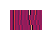

In [ ]:
# Creating dataset of EKMs [MIT-BIHDB]
import gc

users_ecg_file = list(ecg_dict.keys())

for index, usr_ecg_file in enumerate(users_ecg_file):
  pretier_print("begin", index, usr_ecg_file)
  total_ecms = len(ecg_dict[usr_ecg_file][2])
  dataset_extractor("MITDB", usr_ecg_file, ecg_dict[usr_ecg_file], total_ecms)
  pretier_print("end", index, usr_ecg_file)
  gc.collect()
  # break

# EKM dataset creation (PTBDB)


> PTBDB





In [ ]:
train_path = f'EKM_dataset/train'
test_path = f'EKM_dataset/test'
bpf = 5
peaks_window = bpf-1

In [ ]:
# Creating dict of ECG signal of users for MIT-BIH dataset
ecg_dict = {}
fs = 1000
for index, usr_ecg_file in enumerate(users_ecg_file):
  pretier_print("begin", index, usr_ecg_file)

  norm_ecg, distance, peaks = dataset_ecg_dict(usr_ecg_file, fs)
  ecg_dict[usr_ecg_file] = [norm_ecg, distance, peaks]

  pretier_print("end", index, usr_ecg_file)

Streaming output truncated to the last 5000 lines.
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-14 02:25:45

------------------------------
2023-08-14 02:25:45
-> User No.165

s0304lre.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-14 02:25:46

------------------------------
2023-08-14 02:25:46
-> User No.166

s0217lre.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-14 02:25:46

------------------------------
2023-08-14 02:25:46
-> User No.167

s0286lre.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-14 02:25:46

------------------------------
2023-08-14 02:25:46
-> User No.168

s0205_re.dat
. Getting peaks of ecg signal of user
. C

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls -ltrh /content/drive/MyDrive/ECG\ project

total 4.0K
drwx------ 2 root root 4.0K Aug 10 01:23 'N. Mokhtari'


In [ ]:
# Name of the ecg file
saved_ecg_dict_file_name = 'PTBDB_ecg_dict.txt'

# Define the source file path
source_file_path = saved_ecg_dict_file_name

# Define the destination directory path in Google Drive
destination_directory = '/content/drive/MyDrive/ECG project'

In [ ]:
variable_to_file_to_drive_save(ecg_dict, saved_ecg_dict_file_name)

ECG dict have been saved. Continue running cell's from here!

Todos:
- [x] changing the way EKMs being named
- [x] giving the right user's file name to the dataset extractor

<br/>
#temprorary

In [ ]:
f"{destination_directory}/{saved_ecg_dict_file_name}"

'/content/drive/MyDrive/ECG project/PTBDB_ecg_dict.txt'

In [ ]:
ecg_dict = loading_drive_saved_obj_to_variable(f"{destination_directory}/{saved_ecg_dict_file_name}")

In [ ]:
ecg_dict.keys()

dict_keys(['s0014lre.dat', 's0006_re.dat', 's0313lre.dat', 's0098lre.dat', 's0306lre.dat', 's0408lre.dat', 's0119lre.dat', 's0361lre.dat', 's0117lre.dat', 's0239lre.dat', 's0142lre.dat', 's0058lre.dat', 's0068lre.dat', 's0377lre.dat', 's0513_re.dat', 's0490_re.dat', 's0460_re.dat', 's0401lre.dat', 's0224_re.dat', 's0493_re.dat', 's0317lre.dat', 's0080lre.dat', 's0450_re.dat', 's0303lre.dat', 's0079lre.dat', 's0452_re.dat', 's0281lre.dat', 's0132lre.dat', 's0116lre.dat', 's0258lre.dat', 's0160lre.dat', 's0193_re.dat', 's0111lre.dat', 's0213lre.dat', 's0309lre.dat', 's0397lre.dat', 's0329lre.dat', 's0243lre.dat', 's0459_re.dat', 's0201_re.dat', 's0534_re.dat', 's0318lre.dat', 's0471_re.dat', 's0226lre.dat', 's0307lre.dat', 's0101lre.dat', 's0557_re.dat', 's0287lre.dat', 's0330lre.dat', 's0415lre.dat', 's0249lre.dat', 's0380lre.dat', 's0510_re.dat', 's0194lre.dat', 's0223_re.dat', 's0351lre.dat', 's0182_re.dat', 's0496_re.dat', 's0271lre.dat', 's0358lre.dat', 's0046lre.dat', 's0010_re.dat

In [ ]:
ptb_labeling_dict.keys()

dict_keys(['184', '167', '147', '058', '088', '202', '041', '146', '009', '057', '294', '034', '091', '068', '054', '144', '273', '049', '226', '175', '288', '232', '160', '211', '015', '157', '079', '219', '152', '085', '172', '111', '101', '179', '230', '060', '086', '084', '193', '194', '213', '231', '267', '150', '067', '074', '278', '222', '118', '138', '095', '127', '158', '200', '121', '285', '131', '059', '293', '106', '094', '039', '259', '249', '012', '220', '141', '004', '290', '208', '130', '236', '286', '017', '032', '099', '056', '001', '247', '148', '279', '221', '103', '107', '128', '006', '262', '186', '098', '166', '289', '271', '005', '163', '216', '027', '116', '023', '256', '241', '291', '029', '042', '035', '181', '275', '192', '045', '206', '053', '218', '014', '242', '020', '142', '185', '105', '051', '145', '264', '177', '019', '036', '108', '268', '010', '072', '011', '269', '100', '227', '282', '115', '024', '277', '022', '260', '043', '037', '252', '283', '0

In [ ]:
ecg_dict

{'s0014lre.dat': [array([-0.17415332, -0.17505808, -0.17595816, ...,  0.00276354,
         -0.07669216, -0.15654889]),
  694.4149659863946,
  array([   375,   1077,   1775,   2478,   3189,   3889,   4595,   5300,
           6011,   6711,   7411,   8115,   8813,   9512,  10207,  10906,
          11613,  12312,  13006,  13699,  14393,  15084,  15772,  16461,
          17156,  17846,  18539,  19230,  19925,  20617,  21310,  22003,
          22700,  23389,  24079,  24769,  25466,  26162,  26855,  27548,
          28240,  28938,  29631,  30323,  31013,  31710,  32401,  33094,
          33786,  34480,  35180,  35874,  36566,  37266,  37962,  38660,
          39353,  40051,  40743,  41440,  42135,  42833,  43534,  44229,
          44925,  45622,  46324,  47018,  47713,  48408,  49106,  49800,
          50494,  51189,  51884,  52585,  53273,  53967,  54662,  55364,
          56058,  56754,  57447,  58143,  58843,  59537,  60231,  60926,
          61623,  62324,  63017,  63712,  64408,  65107, 

In [ ]:
ptb_labeling_dict

{'047': ['s0160lre.dat',
  's0167lre.dat',
  's0163lre.hea',
  's0160lre.xyz',
  's0163lre.xyz',
  'index.html',
  's0163lre.dat',
  's0160lre.hea',
  's0167lre.hea',
  's0167lre.xyz'],
 '231': ['s0455_re.hea', 'index.html', 's0455_re.xyz', 's0455_re.dat'],
 '284': ['s0551_re.dat',
  's0543_re.hea',
  's0543_re.xyz',
  'index.html',
  's0552_re.dat',
  's0552_re.xyz',
  's0551_re.hea',
  's0552_re.hea',
  's0551_re.xyz',
  's0543_re.dat'],
 '168': ['s0032_re.xyz',
  's0032_re.hea',
  's0032_re.dat',
  's0033_re.hea',
  'index.html',
  's0033_re.dat',
  's0033_re.xyz'],
 '220': ['s0442_re.hea', 'index.html', 's0442_re.dat', 's0442_re.xyz'],
 '271': ['s0509_re.xyz', 's0509_re.dat', 'index.html', 's0509_re.hea'],
 '133': ['index.html', 's0393lre.xyz', 's0393lre.hea', 's0393lre.dat'],
 '279': ['s0533_re.xyz',
  's0531_re.dat',
  's0533_re.dat',
  's0531_re.xyz',
  's0532_re.xyz',
  'index.html',
  's0534_re.hea',
  's0532_re.dat',
  's0531_re.hea',
  's0534_re.xyz',
  's0533_re.hea',
  's0

In [ ]:
# Just for checking if the replacing the name
# of keys in ecg_dict process is being done correctly

ecg_dict_ptb_new = {}
counter = 0

for ecg_key in ecg_dict.keys():
  user_key = ptb_labeling_file_to_user[ecg_key]
  ecg_dict_ptb_new[f"{user_key}.{counter}.dat"] = ecg_dict[ecg_key]
  counter += 1

In [ ]:
# Replacing the name of keys in ecg_dict with users' ids
ecg_dict_ptb = {}
counter = 0

for ecg_key in ecg_dict.keys():
  flag = False
  for user_id in ptb_labeling_dict.keys():
    for _, val in enumerate(ptb_labeling_dict[user_id]):
      if val == ecg_key:
        ecg_dict_ptb[f"{user_id}.{counter}.dat"] = ecg_dict[ecg_key]
        counter += 1
        flag = True
        break
    if flag == True:
      break

In [ ]:
# Checked
ecg_dict_ptb_new == ecg_dict_ptb

True

------------------------------
2023-08-14 02:53:17
-> User No.0

001.0.dat
. Getting EKMs

2023-08-14 02:53:19

------------------------------
2023-08-14 02:53:19
-> User No.1

125.1.dat
. Getting EKMs

2023-08-14 02:53:20

------------------------------
2023-08-14 02:53:20
-> User No.2

084.2.dat
. Getting EKMs

2023-08-14 02:53:21

------------------------------
2023-08-14 02:53:22
-> User No.3

029.3.dat
. Getting EKMs

2023-08-14 02:53:24

------------------------------
2023-08-14 02:53:24
-> User No.4

104.4.dat
. Getting EKMs

2023-08-14 02:53:27

------------------------------
2023-08-14 02:53:27
-> User No.5

091.5.dat
. Getting EKMs

2023-08-14 02:53:29

------------------------------
2023-08-14 02:53:29
-> User No.6

035.6.dat
. Getting EKMs

2023-08-14 02:53:31

------------------------------
2023-08-14 02:53:31
-> User No.7

091.7.dat
. Getting EKMs

2023-08-14 02:53:33

------------------------------
2023-08-14 02:53:33
-> User No.8

030.8.dat
. Getting EKMs

2023-08-14 02

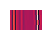

In [ ]:
# Creating dataset of EKMs [PTBDB]
import gc

users_ecg_file = list(ecg_dict_ptb.keys())

for index, usr_ecg_file in enumerate(users_ecg_file):
  pretier_print("begin", index, usr_ecg_file)
  total_ecms = len(ecg_dict_ptb[usr_ecg_file][2])
  dataset_extractor("PTBDB", usr_ecg_file, ecg_dict_ptb[usr_ecg_file], total_ecms)
  pretier_print("end", index, usr_ecg_file)
  gc.collect()
  # break

# Compressing dataset, saving it in drive and Uncompressing it

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Compressing the 5bpf dataset
! tar -czvf EKM_PTBDB_5bpf.tar.gz EKM_dataset

Streaming output truncated to the last 5000 lines.
EKM_dataset/train/5bpf-ekm-PTBDB-train-236-7.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-074-7.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-212-24.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-026-16.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-045-14.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-101-48.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-243-19.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-223-21.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-142-6.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-002-4.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-020-25.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-081-8.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-264-22.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-066-20.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-289-14.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-013-16.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-206-1.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-050-41.png
EKM_dataset/train/5bpf-ekm-PTBDB-train-079-7.png
EKM_da

In [ ]:
! ls -ltrh

total 8.9M
drwxr-xr-x 1 root root 4.0K Aug 10 19:19 sample_data
drwxr-xr-x 3 root root 4.0K Aug 13 13:02 physionet.org
drwxr-xr-x 4 root root 4.0K Aug 13 13:04 EKM_dataset
drwx------ 5 root root 4.0K Aug 13 13:49 drive
-rw-r--r-- 1 root root 8.8M Aug 13 13:55 EKM_MIT_DB_5bpf.tar.gz


In [ ]:
# ! file EKM_dataset_5bpf

EKM_dataset_5bpf: gzip compressed data, from Unix, original size modulo 2^32 65658880


In [ ]:
# ! mv EKM_dataset_5bpf EKM_dataset_5bpf.zip

In [ ]:
# Define the source file path
source_file_path = "EKM_PTBDB_5bpf.tar.gz"

# Define the destination directory path in Google Drive
destination_directory = '/content/drive/MyDrive/ECG project'

In [ ]:
import shutil

# Move the EKM_dataset_5bpf.zip to Google Drive
shutil.move(source_file_path, destination_directory)

'/content/drive/MyDrive/ECG project/EKM_PTBDB_5bpf.tar.gz'

In [ ]:
! ls -ltrh /content/drive/MyDrive/ECG\ project

total 8.8M
drwx------ 2 root root 4.0K Aug 10 01:23 'N. Mokhtari'
-rw------- 1 root root 8.8M Aug 13 13:55  EKM_MIT_DB_5bpf.tar.gz


In [ ]:
# Watching the contents of EKM_dataset_5bpf.zip
! tar -tzvf "/content/drive/MyDrive/ECG project/EKM_dataset_5bpf.zip"

-rw-r--r-- root/root       522 2023-07-01 19:07 EKM_dataset/train/5bpf-ekm-train-18184-896.png
<br>
-rw-r--r-- root/root       514 2023-07-01 18:58 EKM_dataset/train/5bpf-ekm-train-19090-1778.png
<br>
-rw-r--r-- root/root       485 2023-07-01 19:14 EKM_dataset/train/5bpf-ekm-train-16265-1040.png

In [ ]:
! ls -ltrh

total 12K
drwxr-xr-x 4 root root 4.0K Aug 14 02:21 EKM_dataset
drwxr-xr-x 1 root root 4.0K Aug 16 13:42 sample_data
drwx------ 5 root root 4.0K Aug 18 16:22 drive


In [ ]:
# Extracting the .tar.zip file of dataset
! tar -xzvf "/content/drive/MyDrive/ECG project/EKM_PTBDB_5bpf.tar.gz"

In [ ]:
! ls /content/EKM_dataset/test | wc -l

2483


# Vectorizing the images

In [ ]:
def vertorizing_png_imges(address):
  # Load the PNG image
  image = Image.open(address)

  # Convert the image to RGB mode
  image = image.convert('RGB')

  # Resize the image to match the input size expected by the CNN
  desired_width = 33
  desired_height = 21
  image = image.resize((desired_width, desired_height))

  # Convert the image to a NumPy array
  image_array = np.array(image)

  # Reshape the array to match the input shape expected by the CNN
  # image_array = image_array.reshape((1, desired_height, desired_width, 3))

  # Normalize the array
  image_array = image_array.astype('float32') / 255.0

  return image_array

In [ ]:
base_path_test = "/content/EKM_dataset/test/"
base_path_train = "/content/EKM_dataset/train/"

In [ ]:
train_x = []
train_y = []

test_x = []
test_y = []

In [ ]:
from IPython.display import clear_output

total_length_train = len(os.listdir(base_path_train))
total_length_test = len(os.listdir(base_path_test))

def progress_bar(index, train_or_test):

  bar_length = 50
  if (train_or_test == "train"):
    total_length = total_length_train
  else:
    total_length = total_length_test

  step = int(total_length / bar_length)
  prgress = int(index / step)

  # Clear the current cell's output
  clear_output(wait=True)

  print("[", end="")

  [print("*", end="") for i in range(prgress)]
  [print("-", end="") for i in range(bar_length - prgress)]
  print("]")
  print(f"{index}/{total_length}")

In [ ]:
# Train data for cnn network input (x_train, y_train)

# Get a list of all files in the <<train>> directory
images_names = os.listdir(base_path_train)

before_run_time = datetime.now()

# Get train_x by vectorization
# and train_y by name of each person in the each image name
for index, img_name in enumerate(images_names):

    img_vector = vertorizing_png_imges(base_path_train + img_name)
    train_x.append(img_vector)

    img_name = img_name.split("-")
    label = img_name[-2]
    train_y.append(label)

    progress_bar(index, "train")

after_run_time = datetime.now()
diff = after_run_time - before_run_time
print(f"This cell took {int(diff.seconds / 60)} minutes to run.")

[**************************************************]
6775/6776
This cell took 3 minutes to run.


In [ ]:
# Test data for cnn network input (x_test, y_test)

# Get a list of all files in the <<test>> directory
images_names = os.listdir(base_path_test)

before_run_time = datetime.now()

# Get test_x by vectorization
# and test_y by name of each person in the each image name
for index, img_name in enumerate(images_names):

    img_vector = vertorizing_png_imges(base_path_test + img_name)
    test_x.append(img_vector)

    img_name = img_name.split("-")
    label = img_name[-2]
    test_y.append(label)

    progress_bar(index, "test")

after_run_time = datetime.now()
diff = after_run_time - before_run_time
print(f"This cell took {int(diff.seconds / 60)} minutes to run.")

[**************************************************]
2512/2513
This cell took 0 minutes to run.


In [ ]:
train_x = np.array(train_x)
train_y = np.array(train_y)

test_x = np.array(test_x)
test_y = np.array(test_y)

In [ ]:
np.unique(train_y)

array(['001', '002', '003', '004', '005', '006', '007', '008', '009',
       '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024', '025', '026', '027',
       '028', '029', '030', '031', '032', '033', '034', '035', '036',
       '037', '038', '039', '040', '041', '042', '043', '044', '045',
       '046', '047', '048', '049', '050', '051', '052', '053', '054',
       '055', '056', '057', '058', '059', '060', '061', '062', '063',
       '064', '065', '066', '067', '068', '069', '070', '071', '072',
       '073', '074', '075', '076', '077', '078', '079', '080', '081',
       '082', '083', '084', '085', '086', '087', '088', '089', '090',
       '091', '092', '093', '094', '095', '096', '097', '098', '099',
       '100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '110', '111', '112', '113', '114', '115', '116', '117',
       '118', '119', '120', '121', '122', '123', '125', '126', '127',
       '128', '129',

In [ ]:
def variable_to_file_to_drive_save(variable, saved_file_name):
  # To save a variable into text file then transfer it into drive

  # Define the source file path and destination path
  source_file_path = saved_file_name
  destination_directory = '/content/drive/MyDrive/ECG project'

  # Writing the variable into a file
  import pickle

  f = open(saved_file_name, 'wb')
  pickle.dump(variable, f)

  import shutil

  # Move the file to Google Drive
  shutil.move(source_file_path, destination_directory)

In [ ]:
def loading_drive_saved_obj_to_variable(destination_path):
  # Loaing an object(variable) being saved into a file (.txt), into a variable
  import pickle

  # Open the file in binary read mode
  with open(destination_path, 'rb') as fi:
      loaded_dict = pickle.load(fi)

  print(loaded_dict)

  return loaded_dict

In [ ]:
! rm /content/drive/MyDrive/ECG\ project/test_x_MITBIH.txt
! rm /content/drive/MyDrive/ECG\ project/test_y_MITBIH.txt

! rm /content/drive/MyDrive/ECG\ project/train_x_MITBIH.txt
! rm /content/drive/MyDrive/ECG\ project/train_y_MITBIH.txt

In [ ]:
# Saving the train_x, train_y, test_x, test_y into text files in drive
variable_to_file_to_drive_save(train_x, "train_x_MITBIH.txt")
variable_to_file_to_drive_save(train_y, "train_y_MITBIH.txt")

variable_to_file_to_drive_save(test_x, "test_x_MITBIH.txt")
variable_to_file_to_drive_save(test_y, "test_y_MITBIH.txt")

In [ ]:
! ls '/content/drive/MyDrive/ECG project' -ltrh

total 2.4G
-rw------- 1 root root 1.6G Jun 25 15:57 ecg_dict.txt
-rw------- 1 root root  21M Jul  1 19:29 EKM_dataset_5bpf.zip
-rw------- 1 root root 343M Jul  7 17:03 train_x.txt
-rw------- 1 root root 845K Jul  7 17:03 train_y.txt
-rw------- 1 root root 211K Jul  7 17:03 test_y.txt
-rw------- 1 root root  86M Jul  7 17:03 test_x.txt
-rw------- 1 root root 239M Jul 21 19:47 MIT-BIHDB_ecg_dict.txt
-rw------- 1 root root 9.2M Jul 21 20:48 EKM_MITBIH_DB_5bpf.tar.gz
-rw------- 1 root root 138M Jul 22 00:24 train_x_MITBIH.txt
-rw------- 1 root root 204K Jul 22 00:24 train_y_MITBIH.txt
-rw------- 1 root root  35M Jul 22 00:24 test_x_MITBIH.txt
-rw------- 1 root root  51K Jul 22 00:24 test_y_MITBIH.txt


# CNN Architecture

> NSRDB

In [ ]:
len(train_x)

43226

In [ ]:
train_x[0].shape

(21, 33, 3)

In [ ]:
def numerical_labels(labels_arr):
  dict_of_labels = {}
  unique_labels = np.unique(labels_arr)

  for i, value in enumerate(unique_labels):
      dict_of_labels[value] = i

  # print(dict_of_labels)

  num_lbls = []
  for lbl in labels_arr:
    num_lbls.append(dict_of_labels[lbl])

  num_lbls = np.array(num_lbls)

  return num_lbls

In [ ]:
numerical_labels(train_y)

array([ 8,  1,  1, ..., 17, 11,  7])

In [ ]:
train_y

array(['16795', '16272', '16272', ..., '19830', '18177', '16786'],
      dtype='<U5')

In [ ]:
label_dict, numerical_train_labels = numerical_labels(train_y)
_, numerical_test_labels = numerical_labels(test_y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Creating the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(21, 33, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.7),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(18, activation='softmax')
])

# Setting Adam optimizer
optimizer = Adam(learning_rate=0.001)

# Compileing the model with the optimizer
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(train_x, numerical_train_labels, epochs=10, batch_size=32)

Epoch 1/10
1351/1351 [==============================] - 57s 40ms/step - loss: 0.4343 - accuracy: 0.8702
Epoch 2/10
1351/1351 [==============================] - 52s 39ms/step - loss: 0.0723 - accuracy: 0.9785
Epoch 3/10
1351/1351 [==============================] - 55s 41ms/step - loss: 0.0485 - accuracy: 0.9844
Epoch 4/10
1351/1351 [==============================] - 55s 40ms/step - loss: 0.0404 - accuracy: 0.9868
Epoch 5/10
1351/1351 [==============================] - 54s 40ms/step - loss: 0.0314 - accuracy: 0.9896
Epoch 6/10
1351/1351 [==============================] - 50s 37ms/step - loss: 0.0325 - accuracy: 0.9892
Epoch 7/10
1351/1351 [==============================] - 43s 32ms/step - loss: 0.0270 - accuracy: 0.9908
Epoch 8/10
1351/1351 [==============================] - 39s 29ms/step - loss: 0.0259 - accuracy: 0.9917
Epoch 9/10
1351/1351 [==============================] - 44s 32ms/step - loss: 0.0237 - accuracy: 0.9917
Epoch 10/10
1351/1351 [==============================] - 39s 29m

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_x, numerical_test_labels, verbose=2)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

337/337 - 3s - loss: 0.0119 - accuracy: 0.9966 - 3s/epoch - 8ms/step
Test Loss: 0.0119
Test Accuracy: 0.9966


> MIT-BIHDB

In [ ]:
len(train_x)

17327

In [ ]:
train_x[0].shape

(21, 33, 3)

In [ ]:
def numerical_labels(labels_arr, dict_of_labels={}):
  # This function change the labels of train and test
  # data to numerical ones.
  # Note: for the test data we should pass the train
  # data labels

  if dict_of_labels == {}:
    unique_labels = np.unique(labels_arr)

    for i, value in enumerate(unique_labels):
        dict_of_labels[value] = i

  # print(dict_of_labels)

  num_lbls = []
  for lbl in labels_arr:
    num_lbls.append(dict_of_labels[lbl])

  num_lbls = np.array(num_lbls)

  return dict_of_labels, num_lbls

In [ ]:
numerical_labels(train_y)

array([27, 47, 28, ..., 22, 40, 42])

In [ ]:
train_y

array(['205', '234', '207', ..., '124', '222', '228'], dtype='<U3')

In [ ]:
len(np.unique(train_y))

48

In [ ]:
label_dict, numerical_train_labels = numerical_labels(train_y)
_, numerical_test_labels = numerical_labels(test_y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Creating the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(21, 33, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.7),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(48, activation='softmax')
])

# Setting Adam optimizer
optimizer = Adam(learning_rate=0.001)

# Compileing the model with the optimizer
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(train_x, numerical_train_labels, epochs=10, batch_size=32)

Epoch 1/10
542/542 [==============================] - 17s 28ms/step - loss: 1.9859 - accuracy: 0.4719
Epoch 2/10
542/542 [==============================] - 13s 23ms/step - loss: 0.6372 - accuracy: 0.8233
Epoch 3/10
542/542 [==============================] - 12s 23ms/step - loss: 0.3995 - accuracy: 0.8860
Epoch 4/10
542/542 [==============================] - 13s 23ms/step - loss: 0.3010 - accuracy: 0.9144
Epoch 5/10
542/542 [==============================] - 13s 23ms/step - loss: 0.2402 - accuracy: 0.9291
Epoch 6/10
542/542 [==============================] - 13s 23ms/step - loss: 0.2125 - accuracy: 0.9335
Epoch 7/10
542/542 [==============================] - 13s 23ms/step - loss: 0.1853 - accuracy: 0.9428
Epoch 8/10
542/542 [==============================] - 12s 22ms/step - loss: 0.1640 - accuracy: 0.9470
Epoch 9/10
542/542 [==============================] - 12s 22ms/step - loss: 0.1530 - accuracy: 0.9518
Epoch 10/10
542/542 [==============================] - 12s 23ms/step - loss: 0.145

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_x, numerical_test_labels, verbose=2)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

134/134 - 1s - loss: 0.1056 - accuracy: 0.9685 - 908ms/epoch - 7ms/step
Test Loss: 0.1056
Test Accuracy: 0.9685


In [ ]:
# Predict the test set
predictions = model.predict(test_x)
predicted_labels = predictions.argmax(axis=1)

# Find the indices of misclassified samples
misclassified_indices = (predicted_labels != numerical_test_labels)

# Get the misclassified inputs
misclassified_actual_labels = numerical_test_labels[misclassified_indices]
misclassified_predicted_labels = predicted_labels[misclassified_indices]

# Print the misclassified inputs and their corresponding labels
for i in range(len(misclassified_actual_labels)):
    print(f"Actual Label: {misclassified_actual_labels[i]}, Predicted Label: {misclassified_predicted_labels[i]}")
    print("-----")


134/134 [==============================] - 1s 10ms/step
Actual Label: 7, Predicted Label: 36
-----
Actual Label: 25, Predicted Label: 37
-----
Actual Label: 43, Predicted Label: 17
-----
Actual Label: 31, Predicted Label: 23
-----
Actual Label: 7, Predicted Label: 4
-----
Actual Label: 5, Predicted Label: 32
-----
Actual Label: 23, Predicted Label: 9
-----
Actual Label: 36, Predicted Label: 5
-----
Actual Label: 8, Predicted Label: 13
-----
Actual Label: 40, Predicted Label: 45
-----
Actual Label: 23, Predicted Label: 41
-----
Actual Label: 29, Predicted Label: 26
-----
Actual Label: 40, Predicted Label: 42
-----
Actual Label: 31, Predicted Label: 41
-----
Actual Label: 23, Predicted Label: 41
-----
Actual Label: 24, Predicted Label: 46
-----
Actual Label: 23, Predicted Label: 9
-----
Actual Label: 8, Predicted Label: 13
-----
Actual Label: 15, Predicted Label: 4
-----
Actual Label: 4, Predicted Label: 28
-----
Actual Label: 31, Predicted Label: 13
-----
Actual Label: 40, Predicted Lab

> PTBDB

In [ ]:
len(train_x)

6776

In [ ]:
train_x[0].shape

(21, 33, 3)

In [ ]:
def numerical_labels(labels_arr, dict_of_labels={}):
  # This function change the labels of train and test
  # data to numerical ones.
  # Note: for the test data we should pass the train
  # data labels

  if dict_of_labels == {}:
    unique_labels = np.unique(labels_arr)

    for i, value in enumerate(unique_labels):
        dict_of_labels[value] = i

  # print(dict_of_labels)

  num_lbls = []
  for lbl in labels_arr:
    num_lbls.append(dict_of_labels[lbl])

  num_lbls = np.array(num_lbls)

  return dict_of_labels, num_lbls

In [ ]:
numerical_labels(train_y)

array([ 24, 112, 121, ..., 216, 116, 233])

In [ ]:
train_y

In [ ]:
len(np.unique(train_y))

290

In [ ]:
label_dict, numerical_train_labels = numerical_labels(train_y)
_, numerical_test_labels = numerical_labels(test_y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Creating the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(21, 33, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.7),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(290, activation='softmax')
])

# Setting Adam optimizer
optimizer = Adam(learning_rate=0.001)

# Compileing the model with the optimizer
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(train_x, numerical_train_labels, epochs=30, batch_size=128)

Epoch 1/30
53/53 [==============================] - 5s 104ms/step - loss: 0.1209 - accuracy: 0.9633
Epoch 2/30
53/53 [==============================] - 4s 67ms/step - loss: 0.1207 - accuracy: 0.9610
Epoch 3/30
53/53 [==============================] - 4s 71ms/step - loss: 0.1120 - accuracy: 0.9644
Epoch 4/30
53/53 [==============================] - 5s 97ms/step - loss: 0.1130 - accuracy: 0.9628
Epoch 5/30
53/53 [==============================] - 6s 121ms/step - loss: 0.1088 - accuracy: 0.9646
Epoch 6/30
53/53 [==============================] - 3s 65ms/step - loss: 0.1188 - accuracy: 0.9619
Epoch 7/30
53/53 [==============================] - 3s 65ms/step - loss: 0.1090 - accuracy: 0.9658
Epoch 8/30
53/53 [==============================] - 4s 85ms/step - loss: 0.1068 - accuracy: 0.9681
Epoch 9/30
53/53 [==============================] - 5s 96ms/step - loss: 0.1268 - accuracy: 0.9575
Epoch 10/30
53/53 [==============================] - 3s 65ms/step - loss: 0.1006 - accuracy: 0.9671
Epoch 1

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_x, numerical_test_labels, verbose=2)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

79/79 - 1s - loss: 1.2666 - accuracy: 0.8770 - 571ms/epoch - 7ms/step
Test Loss: 1.2666
Test Accuracy: 0.8770


In [ ]:
# Predict the test set
predictions = model.predict(test_x)
predicted_labels = predictions.argmax(axis=1)

# Find the indices of misclassified samples
misclassified_indices = (predicted_labels != numerical_test_labels)

# Get the misclassified inputs
misclassified_actual_labels = numerical_test_labels[misclassified_indices]
misclassified_predicted_labels = predicted_labels[misclassified_indices]

# Print the misclassified inputs and their corresponding labels
for i in range(len(misclassified_actual_labels)):
    print(f"Actual Label: {misclassified_actual_labels[i]}, Predicted Label: {misclassified_predicted_labels[i]}")
    print("-----")

79/79 [==============================] - 1s 7ms/step
Actual Label: 196, Predicted Label: 201
-----
Actual Label: 81, Predicted Label: 15
-----
Actual Label: 32, Predicted Label: 221
-----
Actual Label: 89, Predicted Label: 225
-----
Actual Label: 224, Predicted Label: 71
-----
Actual Label: 15, Predicted Label: 18
-----
Actual Label: 79, Predicted Label: 240
-----
Actual Label: 46, Predicted Label: 204
-----
Actual Label: 29, Predicted Label: 39
-----
Actual Label: 31, Predicted Label: 13
-----
Actual Label: 203, Predicted Label: 9
-----
Actual Label: 252, Predicted Label: 24
-----
Actual Label: 33, Predicted Label: 54
-----
Actual Label: 41, Predicted Label: 59
-----
Actual Label: 20, Predicted Label: 24
-----
Actual Label: 176, Predicted Label: 96
-----
Actual Label: 176, Predicted Label: 96
-----
Actual Label: 139, Predicted Label: 225
-----
Actual Label: 38, Predicted Label: 281
-----
Actual Label: 89, Predicted Label: 27
-----
Actual Label: 93, Predicted Label: 54
-----
Actual Lab